# Premier Modèle GAN

Le premier modèle que nous testons est un [Wasserstein GAN](https://arxiv.org/pdf/1701.07875.pdf) avec une pénalité de gradient et un réseau de neurone convolutif. Le principal différence entre un GAN classique et un Wasserstein GAN réside dans la manière dont la fonction de perte est calculée. Le WGAN utilise utilise la distance de Wasserstein pour mesurer la distance entre la distribution réelle et la distribution générée. Cette distance est mieux adaptée pour mesurer la distance entre deux distributions lorsque ces distributions ont des supports de mesure différents. Ce qui permet de remédier à un problème bien connu des GAN, le fait que le générateur génère des données qui sont souvent très similaires (ici, cela entraînerait une faible diversité de scénario générées).

De l'autre côté, les réseaux de neurones convolutifs sont très populaires en Computer Vision. Leur architecture permet de synthétiser l'information présent dans une chaine de valeur (dans le cas d'images, cela représente par exemple des petites parties de l'image) et sont ainsi intéressant lorsque l'on traite de séries temporelles. 
<img src="img/conv_network.png" alt="Texte alternatif" style="width: 800px;">


In [1]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
from tqdm import trange
from utils.network import *
from utils.create_data import *
from utils.data import *
from utils.metrics import plot_tsne

On sélectionne un actif de notre jeu de données. Ici c'est "UK Government Bond - USD Hedged".

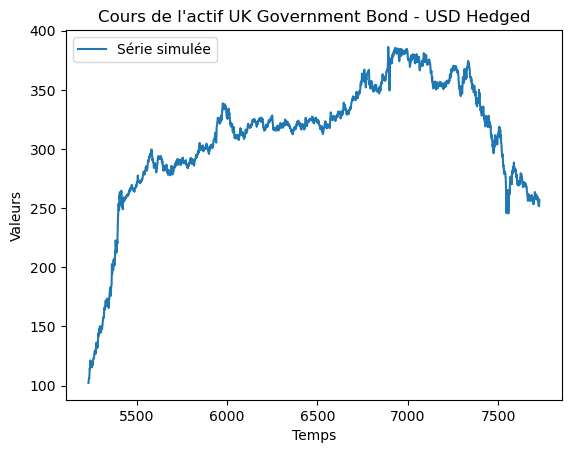

In [2]:
df = pd.read_csv('./data/GANData.csv')
actif = "UK Government Bond - USD Hedged"
simple_plot(df[df['ASSETNAME']==actif]['PRICE'], f"Cours de l'actif {actif}")

On utilisera le LogReturn de la série, définie formellement par:
$ r_t $ à un moment donné $ t $ est défini comme :

$ r_t = \ln\left(\frac{P_t}{P_{t-1}}\right) $

Où :
- $ P_t $ est le prix de l'actif à l'instant $ t $,
- $ P_{t-1} $ est le prix de l'actif à l'instant précédent $ t-1 $,
- $ \ln $ est la fonction logarithme naturel.

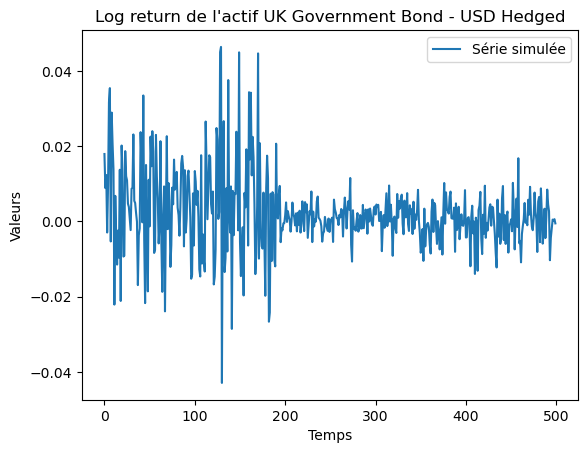

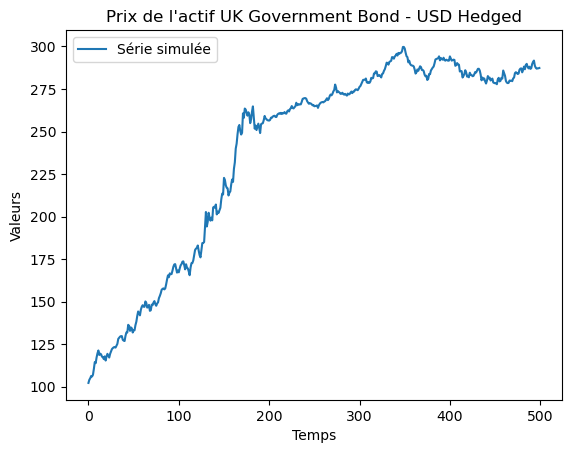

In [3]:
sdf = df[df['ASSETNAME']==actif]['PRICE']
y = np.log(sdf/sdf.shift(1))[1:].to_numpy()
true_y = df[df['ASSETNAME']==actif]['PRICE'].to_numpy()
simple_plot(y[:500], f"Log return de l'actif {actif}")
simple_plot(true_y[:500], f"Prix de l'actif {actif}")

In [9]:
latent_dim = 20 # Dimension du "bruit" d'entrée
ts_dim = 50 # Dimension de sortie
conditional = 10 # Dimension de la partie "commune"

generator = Generator(latent_dim=latent_dim, ts_dim=ts_dim,condition=conditional)
discriminator = Discriminator(ts_dim=ts_dim)
lr_a = 1e-5
lr_b = 1e-5
betas = (0, 0.9)
G_opt = optim.RMSprop(generator.parameters(), lr=lr_a)
D_opt = optim.RMSprop(discriminator.parameters(), lr=lr_b)

D_scheduler = optim.lr_scheduler.CyclicLR(D_opt, base_lr = lr_a, max_lr= 8e-5, step_size_up=100, step_size_down=900, mode ='triangular')
G_scheduler = optim.lr_scheduler.CyclicLR(G_opt, base_lr = lr_b, max_lr= 6e-5, step_size_up=100, step_size_down=900, mode ='triangular')

epochs = 2000
batch_size = 128*2
use_cuda = torch.cuda.is_available()
scorepath = 'test'
print(use_cuda)

train = gen_model(y, generator, discriminator, G_opt, D_opt, batch_size, scorepath, ts_dim, latent_dim, D_scheduler, G_scheduler, conditional=conditional,use_cuda=use_cuda)
train.train_model(epochs=epochs)

True


  0%|          | 0/2000 [00:00<?, ?it/s]/home/onyxia/work/.venv/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:1283: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "
100%|██████████| 2000/2000 [25:02<00:00,  1.33it/s]


<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

Une fois le modèle entraîné, on peut générer un sous échantillon de données.

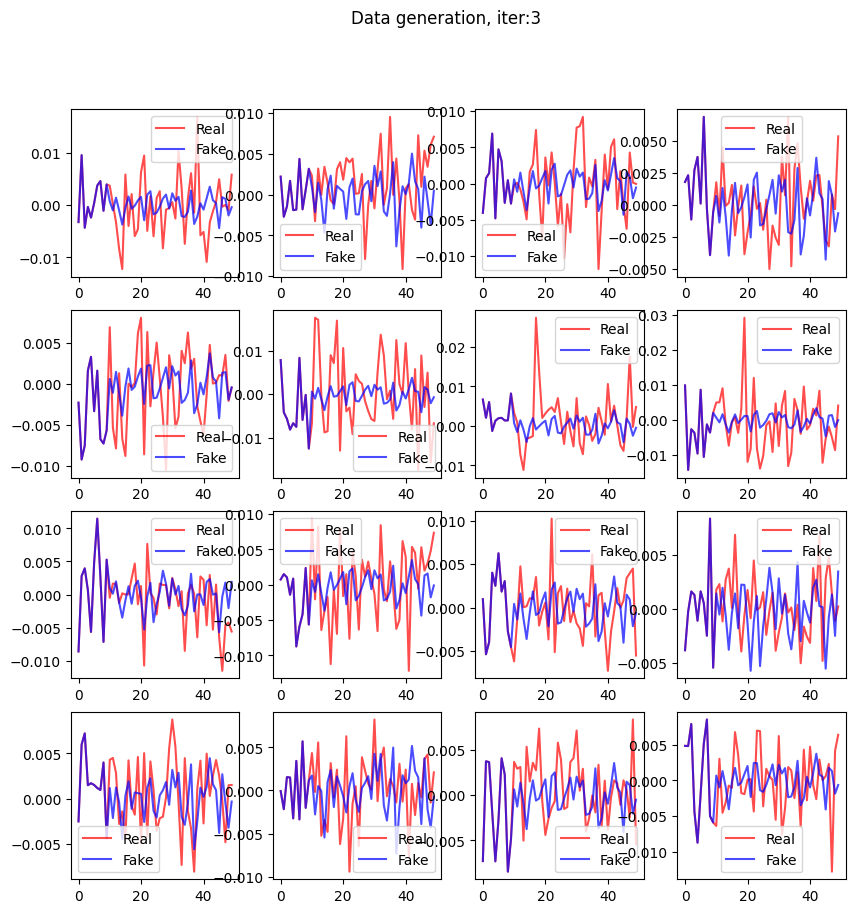

In [10]:
show_examples(train.real_lines, train.fake_lines, size=4)

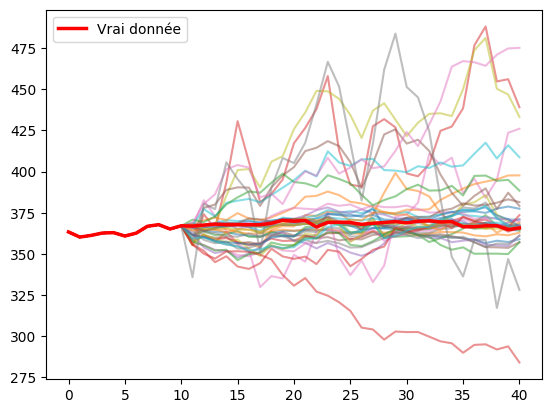

In [11]:
def generate_fake_scenario(input_, true_input, train, amplifier = 1, num = 5):
    for i in range(num):
        conditional = train.conditional
        noise = torch.randn((1, 1, train.latent_dim))*amplifier
        #noise = test
        real_samples = torch.from_numpy(input_[:conditional])
        noise[0][0][:conditional] = real_samples[:conditional]
        noise = noise.cuda()
        v = train.G(noise)
        v[0][0][:conditional] = real_samples[:conditional]
        croissance = np.array(v.float().cpu().detach()[0][0])
        fake_line = np.array([true_input[0]] + [true_input[0] * np.prod(1 + croissance[:i+1]) for i in range(40)])
        plt.plot(fake_line, alpha = 0.5)
    plt.plot(true_input[:len(fake_line)], label=f'Vrai donnée', linewidth=2.5, color="red") 
    plt.legend()
    plt.show()
start = 2000

generate_fake_scenario(y[start:],true_y[start:],train, amplifier = 3,num =40)

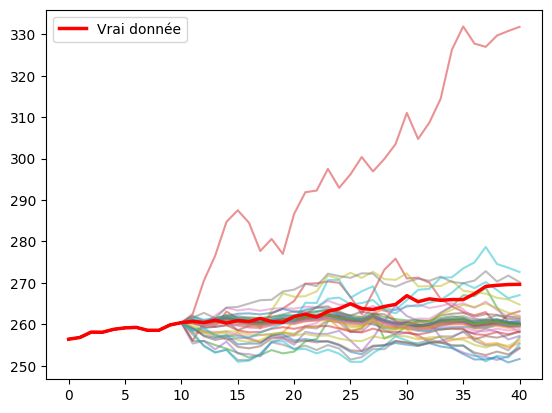

In [15]:
start = 200
generate_fake_scenario(y[start:],true_y[start:],train, amplifier = 2,num = 40)

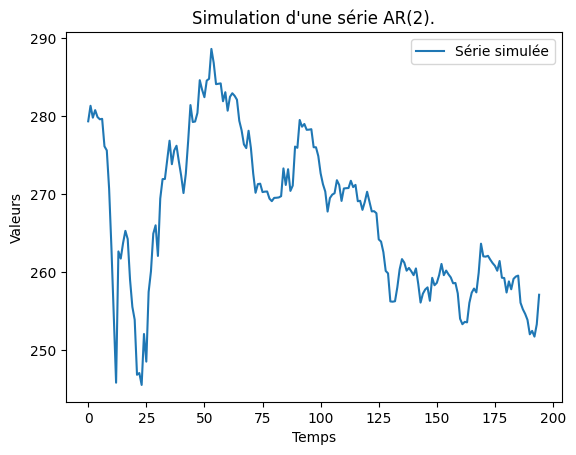

In [13]:
simple_plot(true_y[2300:])

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 150 samples in 0.000s...
[t-SNE] Computed neighbors for 150 samples in 0.069s...
[t-SNE] Computed conditional probabilities for sample 150 / 150
[t-SNE] Mean sigma: 0.021170
[t-SNE] KL divergence after 250 iterations with early exaggeration: 48.428944
[t-SNE] KL divergence after 300 iterations: 0.291691


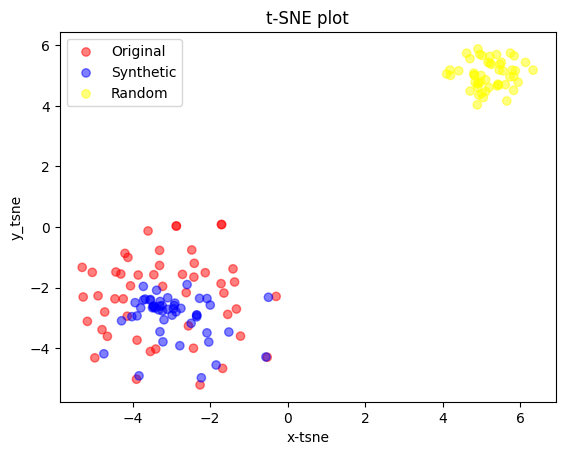

In [14]:
fake , real = train.data.get_samples(G = train.G, latent_dim = train.latent_dim, ts_dim = train.ts_dim, 
                    batch_size=50, conditional= train.conditional, use_cuda=True, data = train.data)
real_array = real.float().cpu().detach().numpy()
fake_array = fake.float().cpu().detach().numpy()
plot_tsne(real_array,fake_array, random=True)

In [50]:
num = 1000
real_mean = []
fake_mean = []
for i in trange(num):
    real, fakes = train.data.get_samples(G=train.G, latent_dim=train.latent_dim, batch_size=train.batch_size, ts_dim=train.ts_dim,conditional=train.conditional,data= train.y, use_cuda=train.use_cuda)
    real_array = real.cpu().detach().numpy().reshape(256,50)
    fake_array = fakes.cpu().detach().numpy().reshape(256,50)/3
    fake_mean.append(np.mean(fake_array))
    real_mean.append(np.mean(real_array))


100%|██████████| 1000/1000 [00:13<00:00, 75.19it/s]


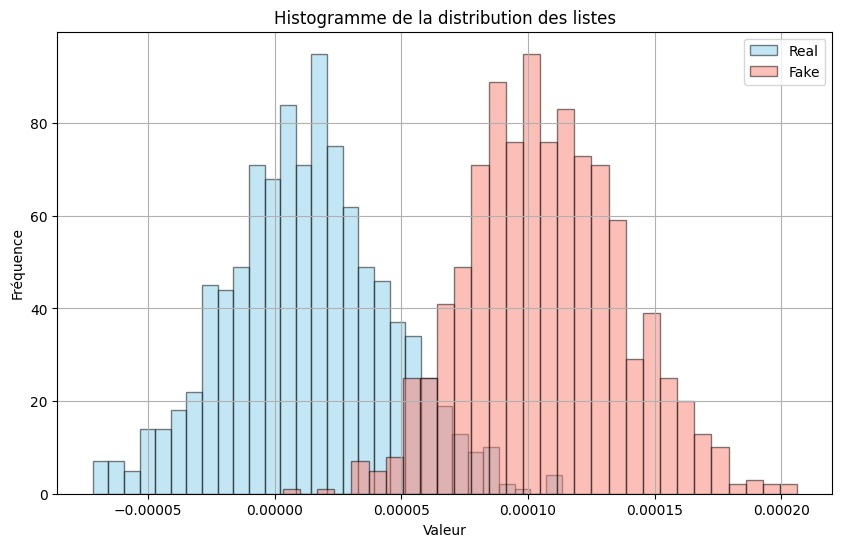

In [51]:
plt.figure(figsize=(10, 6))
plt.hist(real_mean, bins=30, color='skyblue', alpha=0.5, label='Real', edgecolor='black')
plt.hist(fake_mean, bins=30, color='salmon', alpha=0.5, label='Fake', edgecolor='black')
plt.xlabel('Valeur')
plt.ylabel('Fréquence')
plt.title('Histogramme de la distribution des listes')
plt.legend()
plt.grid(True)
plt.show()

# Amérlioration du Modèle

## Entrainement sur plusieurs séries temp

Dans un premier lieu on fixe cond à 0 et on relance l'entrainement

In [ ]:
latent_dim = 20 # Dimension du "bruit" d'entrée
ts_dim = 50 # Dimension de sortie
conditional = 10 # Dimension de la partie "commune"

generator = Generator(latent_dim=latent_dim, ts_dim=ts_dim,condition=conditional)
discriminator = Discriminator(ts_dim=ts_dim)
lr_a = 1e-5
lr_b = 1e-5
betas = (0, 0.9)
G_opt = optim.RMSprop(generator.parameters(), lr=lr_a)
D_opt = optim.RMSprop(discriminator.parameters(), lr=lr_b)

D_scheduler = optim.lr_scheduler.CyclicLR(D_opt, base_lr = lr_a, max_lr= 8e-5, step_size_up=100, step_size_down=900, mode ='triangular')
G_scheduler = optim.lr_scheduler.CyclicLR(G_opt, base_lr = lr_b, max_lr= 6e-5, step_size_up=100, step_size_down=900, mode ='triangular')

epochs = 2000
batch_size = 128*2
use_cuda = torch.cuda.is_available()
scorepath = 'test'
print(use_cuda)

train = gen_model(y, generator, discriminator, G_opt, D_opt, batch_size, scorepath, ts_dim, latent_dim, D_scheduler, G_scheduler, conditional=conditional,use_cuda=use_cuda)
train.train_model(epochs=epochs)

True


  0%|          | 0/2000 [00:00<?, ?it/s]/home/onyxia/work/.venv/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:1283: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "
100%|██████████| 2000/2000 [25:02<00:00,  1.33it/s]


<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

Une fois le modèle entraîné, on peut générer un sous échantillon de données.

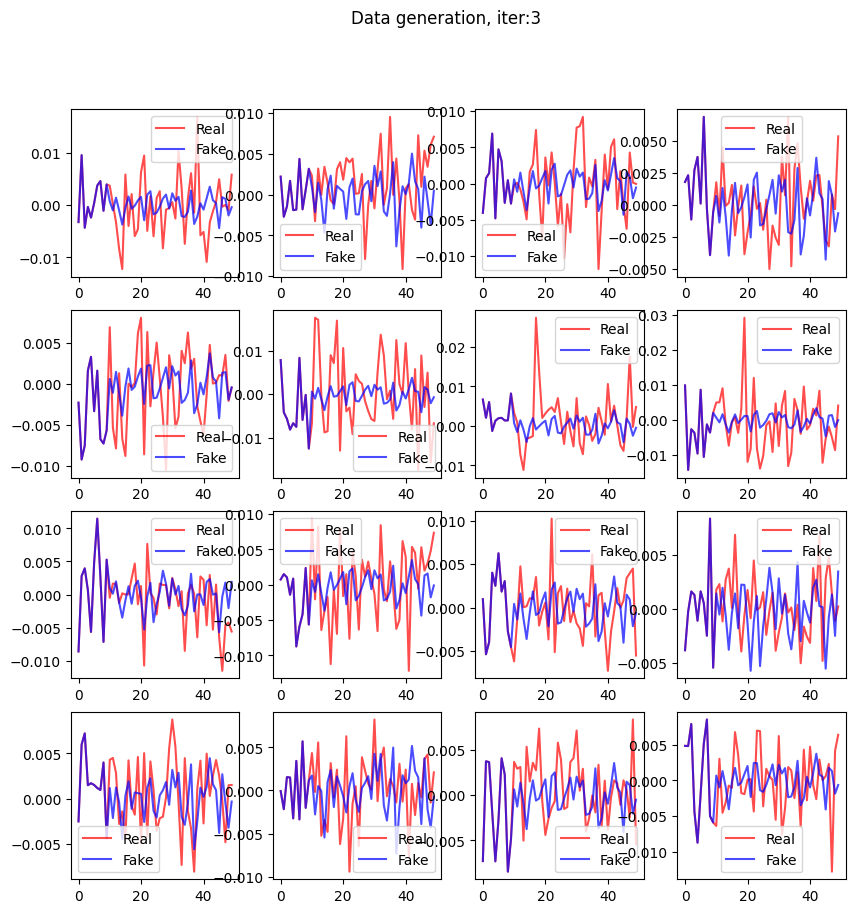

In [ ]:
show_examples(train.real_lines, train.fake_lines, size=4)

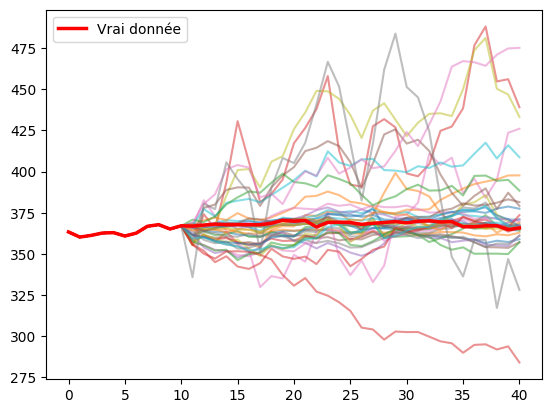

In [ ]:
generate_fake_scenario(y[start:],true_y[start:],train, amplifier = 3,num =40)

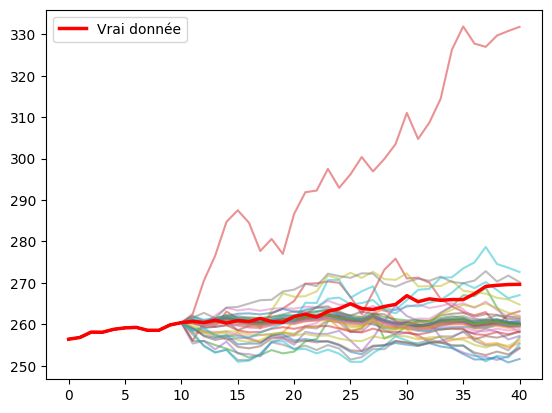

In [ ]:
start = 200
generate_fake_scenario(y[start:],true_y[start:],train, amplifier = 2,num = 40)

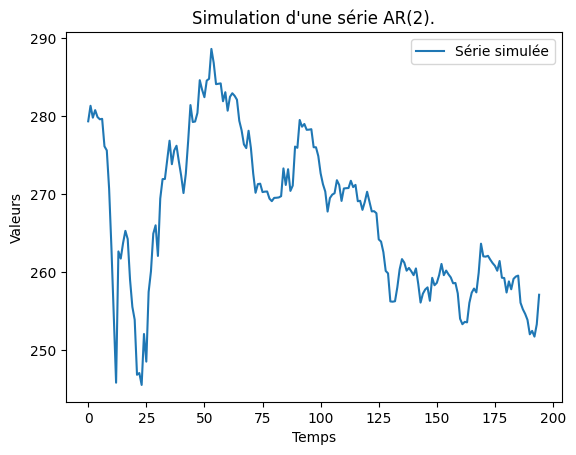

In [ ]:
simple_plot(true_y[2300:])

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 150 samples in 0.000s...
[t-SNE] Computed neighbors for 150 samples in 0.069s...
[t-SNE] Computed conditional probabilities for sample 150 / 150
[t-SNE] Mean sigma: 0.021170
[t-SNE] KL divergence after 250 iterations with early exaggeration: 48.428944
[t-SNE] KL divergence after 300 iterations: 0.291691


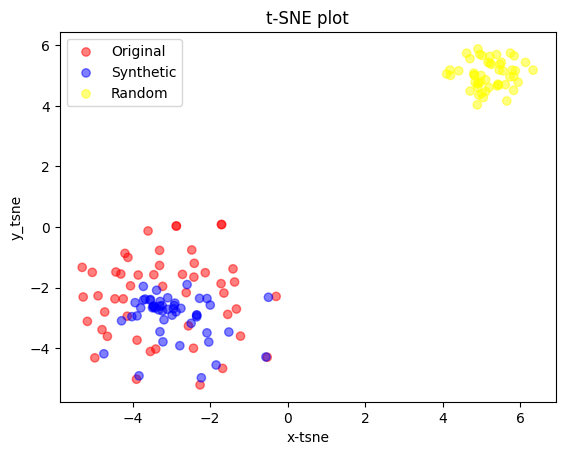

In [ ]:
fake , real = train.data.get_samples(G = train.G, latent_dim = train.latent_dim, ts_dim = train.ts_dim, 
                    batch_size=50, conditional= train.conditional, use_cuda=True, data = train.data)
real_array = real.float().cpu().detach().numpy()
fake_array = fake.float().cpu().detach().numpy()
plot_tsne(real_array,fake_array, random=True)

In [ ]:
num = 1000
real_mean = []
fake_mean = []
for i in trange(num):
    real, fakes = train.data.get_samples(G=train.G, latent_dim=train.latent_dim, batch_size=train.batch_size, ts_dim=train.ts_dim,conditional=train.conditional,data= train.y, use_cuda=train.use_cuda)
    real_array = real.cpu().detach().numpy().reshape(256,50)
    fake_array = fakes.cpu().detach().numpy().reshape(256,50)/3
    fake_mean.append(np.mean(fake_array))
    real_mean.append(np.mean(real_array))


100%|██████████| 1000/1000 [00:13<00:00, 75.19it/s]


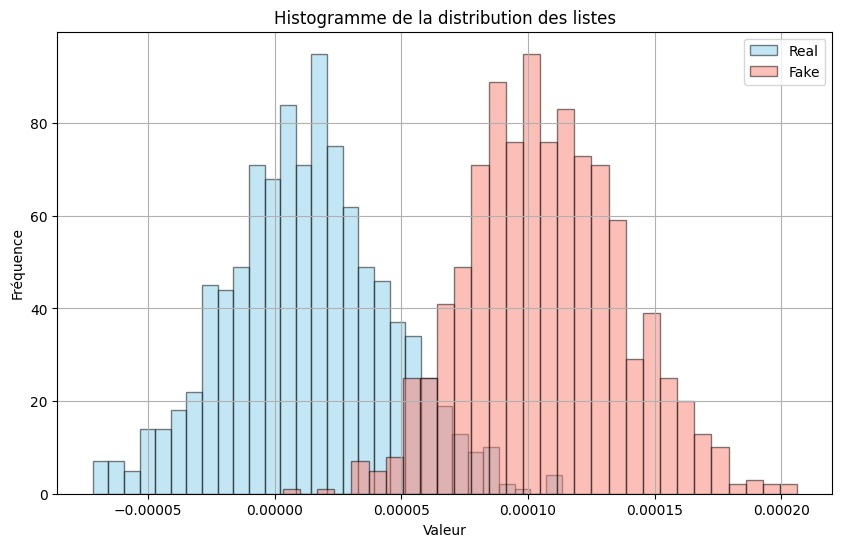

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(real_mean, bins=30, color='skyblue', alpha=0.5, label='Real', edgecolor='black')
plt.hist(fake_mean, bins=30, color='salmon', alpha=0.5, label='Fake', edgecolor='black')
plt.xlabel('Valeur')
plt.ylabel('Fréquence')
plt.title('Histogramme de la distribution des listes')
plt.legend()
plt.grid(True)
plt.show()

Entrainement de plusieurs series à la fois

In [ ]:
filtered_df = pd.DataFrame()

for actif in df['ASSETNAME'].unique():
    actif_df = df[df['ASSETNAME']==actif]['PRICE']
    if len(actif_df) > 2500:
        filtered_df[actif] = actif_df.reset_index(drop=True)

filtered_df = filtered_df.dropna()

print(filtered_df)

      Global Property USD Unhedged  Global Government Bond USD Hedged  \
0                       889.640000                           332.1846   
1                       916.070000                           334.4977   
2                      1006.430000                           336.1632   
3                       983.720000                           340.3984   
4                      1005.670000                           342.6106   
...                            ...                                ...   
2498                   5298.985653                           844.1457   
2499                   5245.844687                           846.3291   
2500                   5194.760579                           843.0870   
2501                   5162.396117                           844.5036   
2502                   5124.047938                           850.3725   

      Europe ex UK Equity - USD Unhedged  UK Equity - USD Unhedged  \
0                            3343.142000             

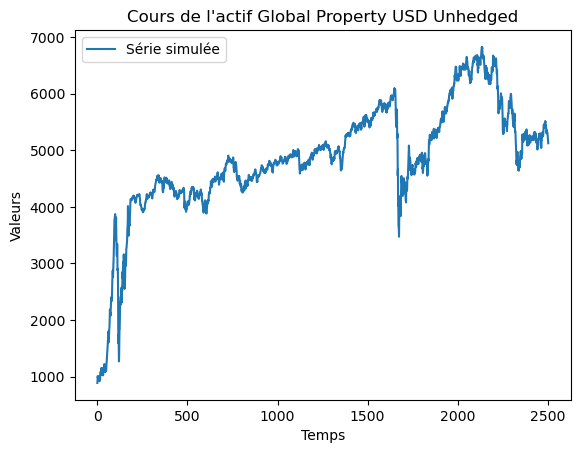

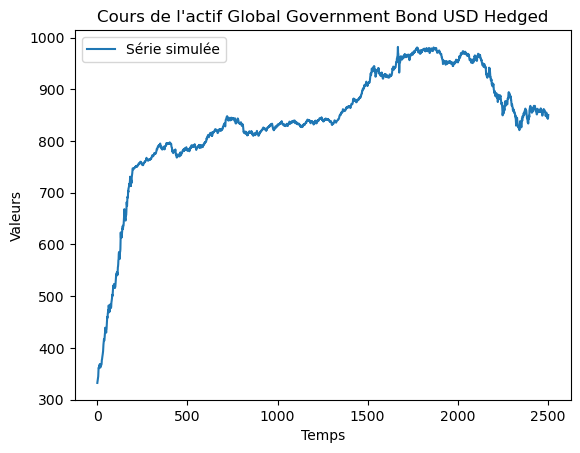

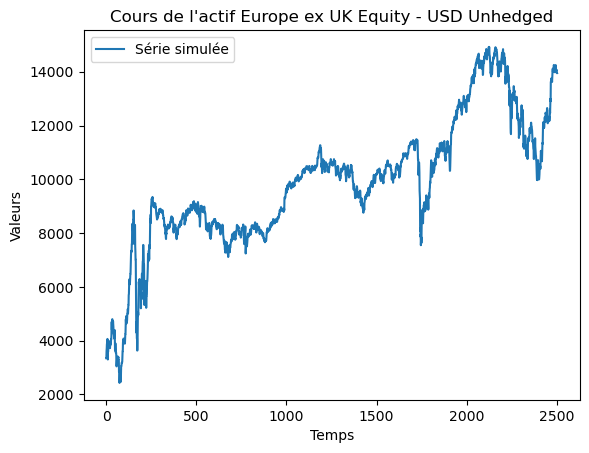

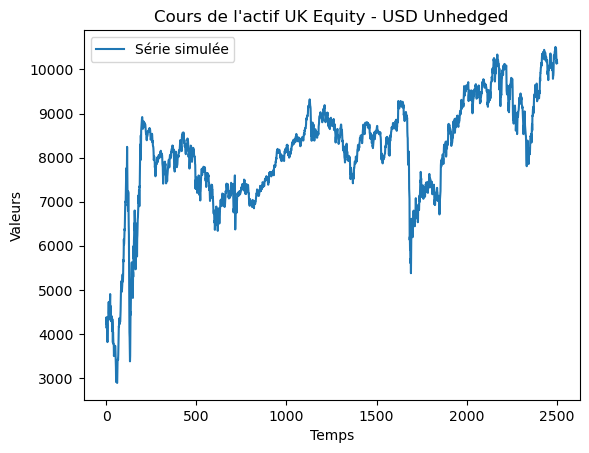

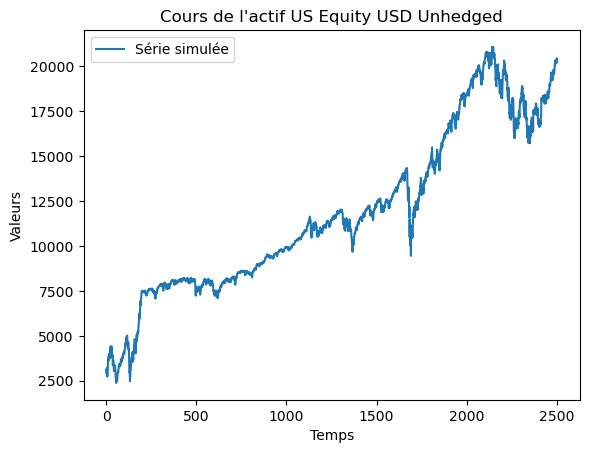

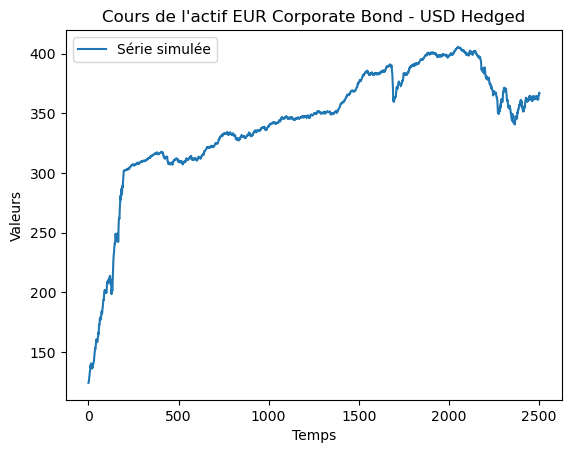

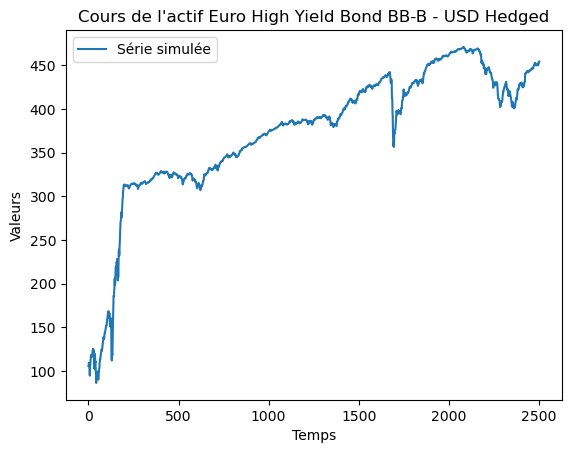

In [ ]:
for column in filtered_df.columns:
    simple_plot(filtered_df[column], f"Cours de l'actif {column}")

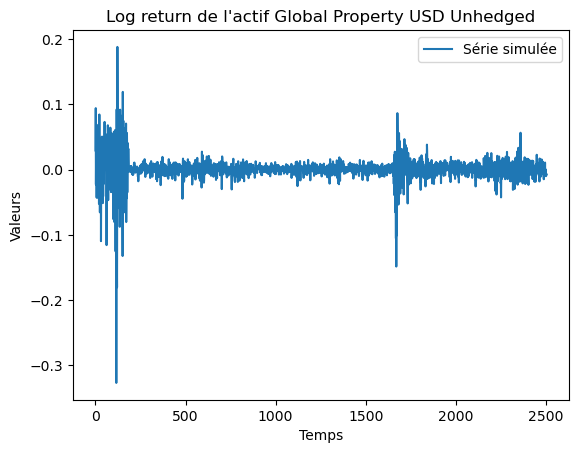

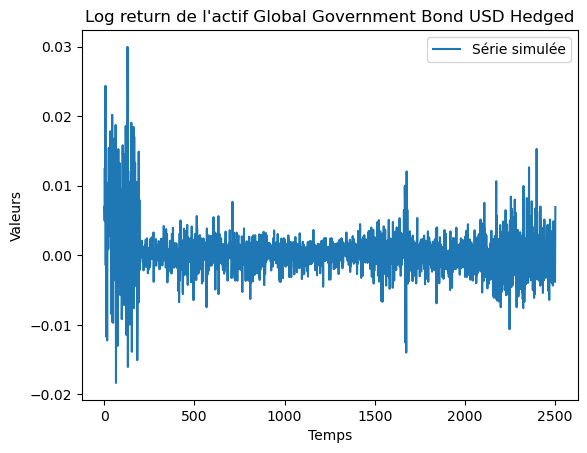

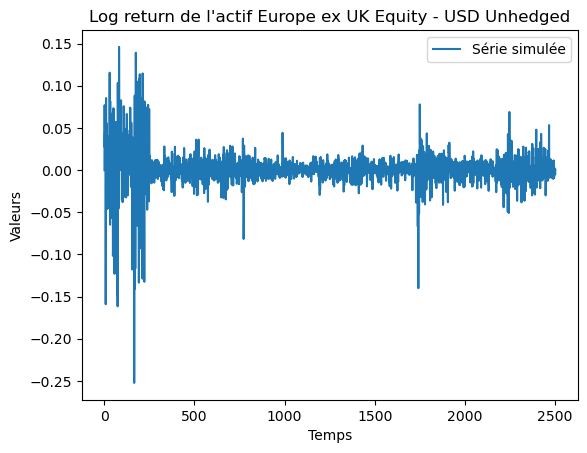

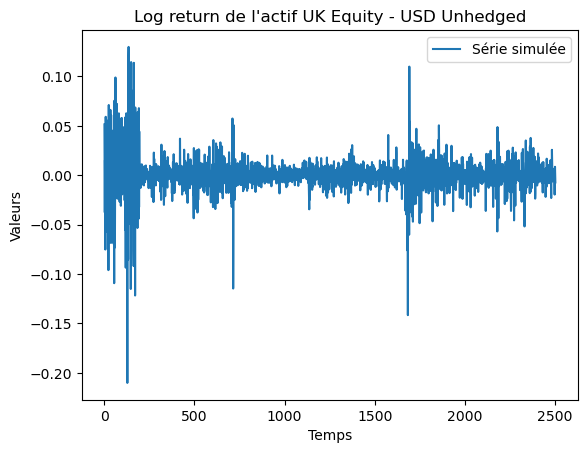

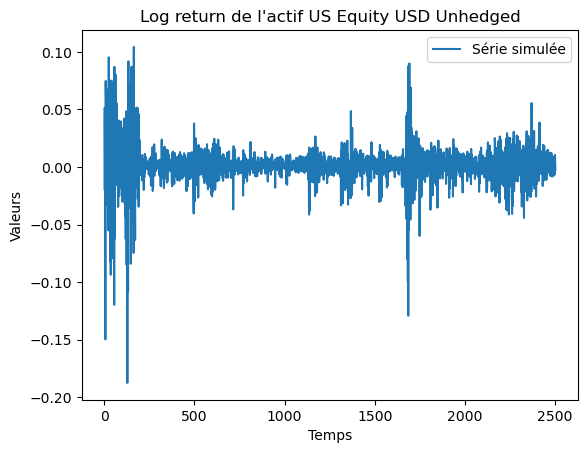

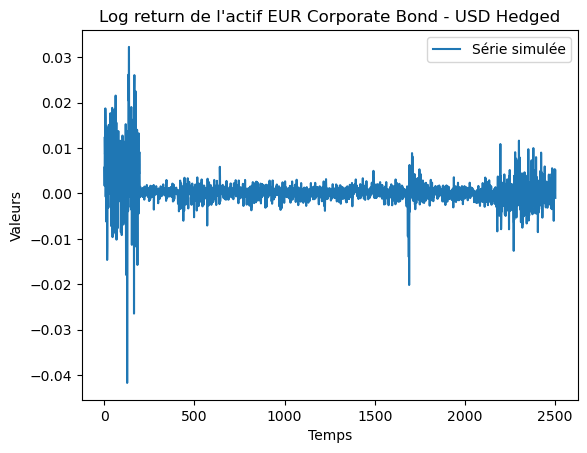

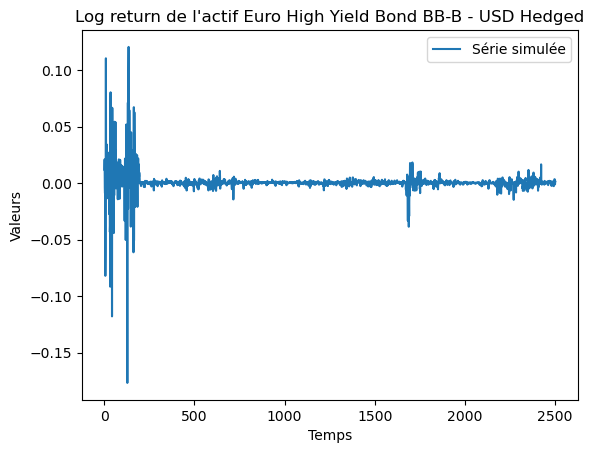

In [ ]:
for column in filtered_df.columns:
    simple_plot(np.log(filtered_df[column]/filtered_df[column].shift(1))[1:], f"Log return de l'actif {column}")

In [ ]:
for column in filtered_df.columns:
    y = filtered_df[column].values
    print(y)

[ 889.64        916.07       1006.43       ... 5194.76057876 5162.39611733
 5124.0479381 ]
[332.1846 334.4977 336.1632 ... 843.087  844.5036 850.3725]
[ 3343.142     3343.142     3610.708    ... 14017.85204  13944.970576
 13947.545476]
[ 4151.048     4370.304     4379.814    ... 10219.162289 10220.375606
 10146.419448]
[ 2946.083     3099.36      3136.193    ... 20409.804858 20451.176585
 20394.436958]
[124.022 124.73  124.94  ... 365.501 367.427 367.067]
[105.701 106.964 109.238 ... 453.376 453.748 454.355]


In [ ]:
latent_dim = 20 # Dimension du "bruit" d'entrée
ts_dim = 50 # Dimension de sortie
conditional = 0 # Dimension de la partie "commune"

generator = Generator(latent_dim=latent_dim, ts_dim=ts_dim,condition=conditional)
discriminator = Discriminator(ts_dim=ts_dim)
lr_a = 1e-5
lr_b = 1e-5
betas = (0, 0.9)
G_opt = optim.RMSprop(generator.parameters(), lr=lr_a)
D_opt = optim.RMSprop(discriminator.parameters(), lr=lr_b)

D_scheduler = optim.lr_scheduler.CyclicLR(D_opt, base_lr = lr_a, max_lr= 8e-5, step_size_up=100, step_size_down=900, mode ='triangular')
G_scheduler = optim.lr_scheduler.CyclicLR(G_opt, base_lr = lr_b, max_lr= 6e-5, step_size_up=100, step_size_down=900, mode ='triangular')

epochs = 2000
batch_size = 128*2
use_cuda = torch.cuda.is_available()
scorepath = 'test'
print(use_cuda)
# Concatenate all columns into a single numpy array
y = np.concatenate([filtered_df[column].values for column in filtered_df.columns])

# Train a single GAN model on the concatenated data
train = gen_model(y, generator, discriminator, G_opt, D_opt, batch_size, scorepath, ts_dim, latent_dim, D_scheduler, G_scheduler, conditional=conditional,use_cuda=use_cuda)
train.train_model(epochs=epochs)

False


  0%|          | 0/2000 [00:00<?, ?it/s]c:\Users\tahah\anaconda3\envs\gan_basique\lib\site-packages\torch\optim\lr_scheduler.py:1333: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "
  1%|          | 19/2000 [01:09<2:01:35,  3.68s/it]